# https://towardsdatascience.com/model-design-and-selection-with-scikit-learn-18a29041d02a

Author: Sandra Godinho Silva \
Most updated version: 0.1 (1/01/2021)

## Purpose
State the purpose of the notebook.

## Methodology
Quickly describe assumptions and processing steps.

## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:
- todo 1;
- todo 2;
- todo 3.

## Results
Describe and comment the most important results.

## Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

## Library import
We import all the required Python libraries

In [1]:
###############################################################################
#                          1. Importing Libraries                             #
###############################################################################
# For reading, visualizing, and preprocessing data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler#, Imputer
from sklearn.pipeline import Pipeline
from sklearn import metrics

# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier


# Data import
We retrieve all the required data for the analysis.

In [2]:
#df = pd.read_csv("cog_genus_counts.csv", index_col=0)
df=pd.read_csv("cazymes_PA_metadata.csv")
df.head()

,GT2_Glycos_transf_2,GT9,GT4,GT5,GT25,GH30_1,GH3,GH144,GT51,GH25,...,CBM77,CBM6+GH3,GH51+CBM35,GH18+CBM73,CBM32+PL7_5,PL7_5+4.2.2.3,CBM47+PL7_3,CBM16+CBM47+PL7_3,CBM47+CBM6+CBM47+CBM6,Origin
0,1,1,1,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,Non_marine
1,1,1,1,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,Marine
2,1,1,1,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,Marine
3,1,1,1,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,Marine
4,1,0,1,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,Non_marine


In [3]:
category= "Origin"
X = df.copy()
y = X.pop(category).values

# Stratified k-fold needs np arrays
#X = X.to_numpy()

In [4]:
labels=df.drop(columns=category).columns
labels_data, label_set = pd.factorize(labels)
label_set

Index(['GT2_Glycos_transf_2', 'GT9', 'GT4', 'GT5', 'GT25', 'GH30_1', 'GH3',
       'GH144', 'GT51', 'GH25',
       ...
       'CBM32+PL6', 'CBM77', 'CBM6+GH3', 'GH51+CBM35', 'GH18+CBM73',
       'CBM32+PL7_5', 'PL7_5+4.2.2.3', 'CBM47+PL7_3', 'CBM16+CBM47+PL7_3',
       'CBM47+CBM6+CBM47+CBM6'],
      dtype='object', length=749)

In [5]:
features = df.select_dtypes(include=['int']).columns
num_class = len(np.unique(y))

In [6]:
###############################################################################
#                        3. Create train and test set                         #
###############################################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,
                                                    random_state = 1000)

We will train and tune 18 classifiers and evaluate their performance using the area under the receiver operating curve (AUC).  
Each classifier is given a label denoted by the string contained between parentheses.

In [7]:
###############################################################################
#                               4. Classifiers                                #
###############################################################################
# Create list of tuples with classifier label and classifier object
classifiers = {}
classifiers.update({"LDA": LinearDiscriminantAnalysis()})
classifiers.update({"QDA": QuadraticDiscriminantAnalysis()})
classifiers.update({"AdaBoost": AdaBoostClassifier()})
classifiers.update({"Bagging": BaggingClassifier()})
classifiers.update({"Extra Trees Ensemble": ExtraTreesClassifier()})
classifiers.update({"Gradient Boosting": GradientBoostingClassifier()})
classifiers.update({"Random Forest": RandomForestClassifier()})
classifiers.update({"Ridge": RidgeClassifier()})
classifiers.update({"SGD": SGDClassifier()})
classifiers.update({"BNB": BernoulliNB()})
classifiers.update({"GNB": GaussianNB()})
classifiers.update({"KNN": KNeighborsClassifier()})
classifiers.update({"MLP": MLPClassifier()})
classifiers.update({"LSVC": LinearSVC()})
classifiers.update({"NuSVC": NuSVC()})
classifiers.update({"SVC": SVC()})
classifiers.update({"DTC": DecisionTreeClassifier()})
classifiers.update({"ETC": ExtraTreeClassifier()})

# Create dict of decision function labels
DECISION_FUNCTIONS = {"Ridge", "SGD", "LSVC", "NuSVC", "SVC"}

# Create dict for classifiers with feature_importances_ attribute
FEATURE_IMPORTANCE = {"Gradient Boosting", "Extra Trees Ensemble", "Random Forest"}

In [8]:
###############################################################################
#                             5. Hyper-parameters                             #
###############################################################################
# Initiate parameter grid
parameters = {}

# Update dict with LDA
parameters.update({"LDA": {"classifier__solver": ["svd"], 
                                         }})

# Update dict with QDA
parameters.update({"QDA": {"classifier__reg_param":[0.01*ii for ii in range(0, 101)], 
                                         }})
# Update dict with AdaBoost
parameters.update({"AdaBoost": { 
                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                "classifier__n_estimators": [200],
                                "classifier__learning_rate": [0.001, 0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 1.0]
                                 }})

# Update dict with Bagging
parameters.update({"Bagging": { 
                                "classifier__base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                "classifier__n_estimators": [200],
                                "classifier__max_features": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                "classifier__n_jobs": [-1]
                                }})

# Update dict with Gradient Boosting
parameters.update({"Gradient Boosting": { 
                                        "classifier__learning_rate":[0.15,0.1,0.05,0.01,0.005,0.001], 
                                        "classifier__n_estimators": [200],
                                        "classifier__max_depth": [2,3,4,5,6],
                                        "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                        "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                        "classifier__max_features": ["auto", "sqrt", "log2"],
                                        "classifier__subsample": [0.8, 0.9, 1]
                                         }})


# Update dict with Extra Trees
parameters.update({"Extra Trees Ensemble": { 
                                            "classifier__n_estimators": [200],
                                            "classifier__class_weight": [None, "balanced"],
                                            "classifier__max_features": ["auto", "sqrt", "log2"],
                                            "classifier__max_depth" : [3, 4, 5, 6, 7, 8],
                                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                            "classifier__criterion" :["gini", "entropy"]     ,
                                            "classifier__n_jobs": [-1]
                                             }})


# Update dict with Random Forest Parameters
parameters.update({"Random Forest": { 
                                    "classifier__n_estimators": [200],
                                    "classifier__class_weight": [None, "balanced"],
                                    "classifier__max_features": ["auto", "sqrt", "log2"],
                                    "classifier__max_depth" : [3, 4, 5, 6, 7, 8],
                                    "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                    "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                    "classifier__criterion" :["gini", "entropy"]     ,
                                    "classifier__n_jobs": [-1]
                                     }})

# Update dict with Ridge
parameters.update({"Ridge": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})

# Update dict with SGD Classifier
parameters.update({"SGD": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0],
                            "classifier__penalty": ["l1", "l2"],
                            "classifier__n_jobs": [-1]
                             }})


# Update dict with BernoulliNB Classifier
parameters.update({"BNB": { 
                            "classifier__alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})

# Update dict with GaussianNB Classifier
parameters.update({"GNB": { 
                            "classifier__var_smoothing": [1e-9, 1e-8,1e-7, 1e-6, 1e-5]
                             }})

# Update dict with K Nearest Neighbors Classifier
parameters.update({"KNN": { 
                            "classifier__n_neighbors": list(range(1,31)),
                            "classifier__p": [1, 2, 3, 4, 5],
                            "classifier__leaf_size": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
                            "classifier__n_jobs": [-1]
                             }})

# Update dict with MLPClassifier
parameters.update({"MLP": { 
                            "classifier__hidden_layer_sizes": [(5), (10), (5,5), (10,10), (5,5,5), (10,10,10)],
                            "classifier__activation": ["identity", "logistic", "tanh", "relu"],
                            "classifier__learning_rate": ["constant", "invscaling", "adaptive"],
                            "classifier__max_iter": [100, 200, 300, 500, 1000, 2000],
                            "classifier__alpha": list(10.0 ** -np.arange(1, 10)),
                             }})

parameters.update({"LSVC": { 
                            "classifier__penalty": ["l2"],
                            "classifier__C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100]
                             }})

parameters.update({"NuSVC": { 
                            "classifier__nu": [0.25, 0.50, 0.75],
                            "classifier__kernel": ["linear", "rbf", "poly"],
                            "classifier__degree": [1,2,3,4,5,6],
                             }})

parameters.update({"SVC": { 
                            "classifier__kernel": ["linear", "rbf", "poly"],
                            "classifier__gamma": ["auto"],
                            "classifier__C": [0.1, 0.5, 1, 5, 10, 50, 100],
                            "classifier__degree": [1, 2, 3, 4, 5, 6]
                             }})


# Update dict with Decision Tree Classifier
parameters.update({"DTC": { 
                            "classifier__criterion" :["gini", "entropy"],
                            "classifier__splitter": ["best", "random"],
                            "classifier__class_weight": [None, "balanced"],
                            "classifier__max_features": ["auto", "sqrt", "log2"],
                            "classifier__max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})

# Update dict with Extra Tree Classifier
parameters.update({"ETC": { 
                            "classifier__criterion" :["gini", "entropy"],
                            "classifier__splitter": ["best", "random"],
                            "classifier__class_weight": [None, "balanced"],
                            "classifier__max_features": ["auto", "sqrt", "log2"],
                            "classifier__max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})

# 1. Filter Method: Correlation-Based Feature Selection

Initial len: 1004
Final len: 1004


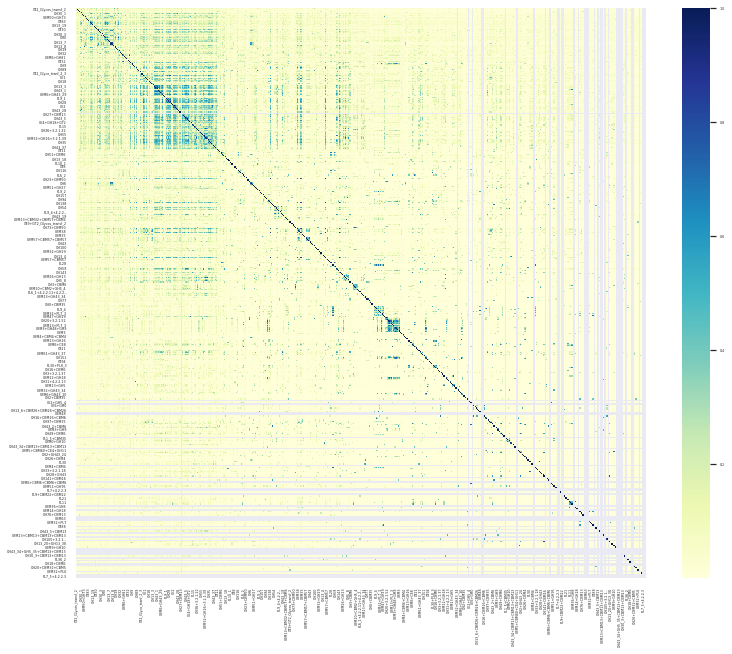

In [15]:
###############################################################################
#              6. Feature Selection: Removing highly correlated features      #
###############################################################################
print("Initial len: " + str(len(X_train)))

# Filter Method: Spearman's Cross Correlation > 0.95
# Make correlation matrix
corr_matrix = X_train.corr(method = "spearman").abs()

# Draw the heatmap
sns.set(font_scale = 0.3)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
plt.savefig("correlation_matrix.png", dpi = 1080)

# Select upper triangle of matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features
X_train = X_train.drop(to_drop, axis = 1)
X_test = X_test.drop(to_drop, axis = 1)

print("Final len: " + str(len(X_train)))

# 2. Wrapper Method: Recursive Feature Elimination with Cross Validation

## 2.a. Tuning the Base Estimator
First you need to select the base estimator to use with RFECV. For the sake of illustration, I will select a Random Forest Classifier as the base. You’re welcome to choose any of the following as the base estimator.  

Once the base estimator is determined, we will tune its hyper-parameters. The reasons to do this are to reduce the risk over-fitting and to maximize the estimator’s performance. To do so, we will create a Scikit-learn Pipeline object that will be used with the Scikit-learn GridSearchCV object.

GridSearchCV will perform an exhaustive search over the hyper-parameter grid and will report the hyper-parameters that will maximize the cross-validated classifier performance. We will set the number of folds to 5.

In [16]:
###############################################################################
#                                Base Estimators                              #
###############################################################################
# Create dict for classifiers with feature_importances_ attribute
FEATURE_IMPORTANCE = {"Gradient Boosting", "Extra Trees Ensemble", "Random Forest"}

In [17]:
###############################################################################
#                     7. Tuning a classifier to use with RFECV                #
###############################################################################
# Define classifier to use as the base of the recursive feature elimination algorithm
selected_classifier = "Random Forest"   # CHANGEABLE
classifier = classifiers[selected_classifier]

# Tune classifier (Took = 4.8 minutes)
    
# Scale features via Z-score normalization
scaler = StandardScaler()

# Define steps in pipeline
steps = [("scaler", scaler), ("classifier", classifier)]

# Initialize Pipeline object
pipeline = Pipeline(steps = steps)
  
# Define parameter grid
param_grid = parameters[selected_classifier]

# Initialize GridSearch object
gscv = GridSearchCV(pipeline, param_grid, cv = 5,  n_jobs= -1, verbose = 1, scoring = "roc_auc")
                  
# Fit gscv
print(f"Now tuning {selected_classifier}.")
gscv.fit(X_train, np.ravel(y_train))  

# Get best parameters and score
best_params = gscv.best_params_
best_score = gscv.best_score_
        
# Update classifier parameters
tuned_params = {item[12:]: best_params[item] for item in best_params}
classifier.set_params(**tuned_params)

Now tuning Random Forest. Go grab a beer or something.
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  5.4min finished


RandomForestClassifier(class_weight='balanced', max_depth=8,
                       max_features='sqrt', min_samples_leaf=0.005,
                       min_samples_split=0.01, n_estimators=200, n_jobs=-1)

## 2.b. Recursively Selecting Features with the Tuned Estimator

Once we tuned our base estimator, we will create another pipeline similar to the first one, but this one will have the tuned classifier in the second step.  
Since Scikit-learn Pipeline object does not have feature_importances_ or coef_attributes, we will have to create our own pipeline object if we want to use it with RFECV.

In [18]:
###############################################################################
#                  8. Custom pipeline object to use with RFECV                #
###############################################################################
# Select Features using RFECV
class PipelineRFE(Pipeline):
    # Source: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

Finally, we can use RFECV with our new pipeline.

In [39]:
###############################################################################
#   9. Feature Selection: Recursive Feature Selection with Cross Validation   #
###############################################################################
# Define pipeline for RFECV
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps = steps)

# Initialize RFECV object
feature_selector = RFECV(pipe, cv = 2, step = 1, scoring = "roc_auc", verbose = 2)

# Fit RFECV
feature_selector.fit(X_train, np.ravel(y_train))

# Get selected features
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()

Fitting estimator with 704 features.
Fitting estimator with 703 features.
Fitting estimator with 702 features.
Fitting estimator with 701 features.
Fitting estimator with 700 features.
Fitting estimator with 699 features.
Fitting estimator with 698 features.
Fitting estimator with 697 features.
Fitting estimator with 696 features.
Fitting estimator with 695 features.
Fitting estimator with 694 features.
Fitting estimator with 693 features.
Fitting estimator with 692 features.
Fitting estimator with 691 features.
Fitting estimator with 690 features.
Fitting estimator with 689 features.
Fitting estimator with 688 features.
Fitting estimator with 687 features.
Fitting estimator with 686 features.
Fitting estimator with 685 features.
Fitting estimator with 684 features.
Fitting estimator with 683 features.
Fitting estimator with 682 features.
Fitting estimator with 681 features.
Fitting estimator with 680 features.
Fitting estimator with 679 features.
Fitting estimator with 678 features.
F

Now let’s visualize the results

In [36]:
(len(feature_names) + 1)/10

70.5

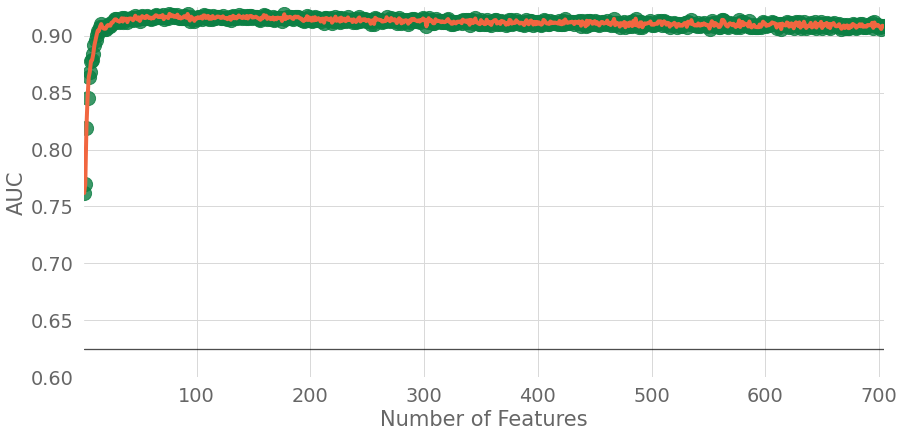

In [40]:
###############################################################################
#                             10. Performance Curve                           #
###############################################################################
# Get Performance Data
performance_curve = {"Number of Features": list(range(1, (len(feature_names) + 1))),
                    "AUC": feature_selector.grid_scores_}
performance_curve = pd.DataFrame(performance_curve)

# Performance vs Number of Features
# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})
colors = sns.color_palette("RdYlGn", 20)
line_color = colors[3]
marker_colors = colors[-1]

# Plot
f, ax = plt.subplots(figsize=(13, 6.5))
sns.lineplot(x = "Number of Features", y = "AUC", data = performance_curve,
             color = line_color, lw = 4, ax = ax)
sns.regplot(x = performance_curve["Number of Features"], y = performance_curve["AUC"],
            color = marker_colors, fit_reg = False, scatter_kws = {"s": 200}, ax = ax)

# Axes limits
plt.xlim(0.5, len(feature_names)+0.5)
plt.ylim(0.60, 0.925)

# Generate a bolded horizontal line at y = 0
ax.axhline(y = 0.625, color = 'black', linewidth = 1.3, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig("performance_curve.png", dpi = 1080)

In [41]:
###############################################################################
#                11. Feature Selection: Recursive Feature Selection           #
###############################################################################
# Define pipeline for RFECV
steps = [("scaler", scaler), ("classifier", classifier)]
pipe = PipelineRFE(steps = steps)

# Initialize RFE object
feature_selector = RFE(pipe, n_features_to_select = 10, step = 1, verbose = 1)

# Fit RFE
feature_selector.fit(X_train, np.ravel(y_train))

# Get selected features labels
feature_names = X_train.columns
selected_features = feature_names[feature_selector.support_].tolist()

Fitting estimator with 704 features.
Fitting estimator with 703 features.
Fitting estimator with 702 features.
Fitting estimator with 701 features.
Fitting estimator with 700 features.
Fitting estimator with 699 features.
Fitting estimator with 698 features.
Fitting estimator with 697 features.
Fitting estimator with 696 features.
Fitting estimator with 695 features.
Fitting estimator with 694 features.
Fitting estimator with 693 features.
Fitting estimator with 692 features.
Fitting estimator with 691 features.
Fitting estimator with 690 features.
Fitting estimator with 689 features.
Fitting estimator with 688 features.
Fitting estimator with 687 features.
Fitting estimator with 686 features.
Fitting estimator with 685 features.
Fitting estimator with 684 features.
Fitting estimator with 683 features.
Fitting estimator with 682 features.
Fitting estimator with 681 features.
Fitting estimator with 680 features.
Fitting estimator with 679 features.
Fitting estimator with 678 features.
F

KeyboardInterrupt: 